# Information on script

info: You will need 1 excel file with 2 sheets: OD and layout

OD: values with blank already substracted. First column should be called Time, rest ofthe columns should be called by the well name and contain OD values
layout: this contains information on layout and strains. Contains minimum 2 columns, more are optional. 

Columns: 1) Well, 2) name (name of the strain), 3) information_strain(optional), 4) Other....

This script takes in consideration OD values between 0.05 and 0.33 which was the most important for this experiment (can be changed)
This script calculates the slope over a rolling window of 3 hours (can be changed) and calculates the:
median, mean, max and min slope in the time frame.

for data where the blank is already substracted


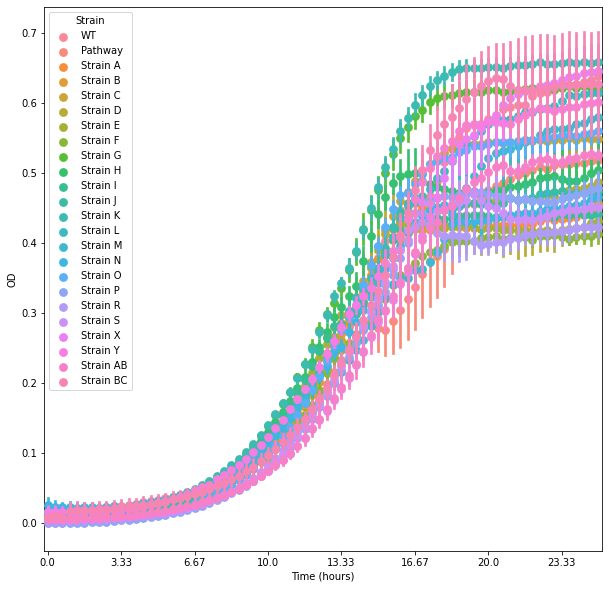

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


data = pd.read_excel('Growth_rate_example.xlsx', sheet_name='OD') #Change path to folder
data.Time = data['Time'].round(2)
layout = pd.read_excel('Growth_rate_example.xlsx', sheet_name='layout') # Change path to folder
layout_dict = dict(zip(layout.Well, layout.name))

layout_info = dict(zip(layout.Well, layout.information_strain)) #Optional
target_dict = dict(zip(layout.Well, layout.Target)) # Optional

df = data.copy()
df = df.melt(id_vars= 'Time', var_name= 'Strain', value_name= 'OD')

df['information'] = df['Strain']
df['Well'] = df['Strain']
df['Target'] = df['Well']
df['Strain'].replace(layout_dict, inplace = True)
df['information'].replace(layout_info, inplace = True)
df['Target'].replace(target_dict, inplace = True)

a = np.arange(0, 75, 10).tolist() #if you want to arange x ticks differently

plt.figure(figsize=(10, 10))
sns.pointplot(data = df, x = 'Time', y = 'OD', join= False, ci = 'sd', hue = 'Strain')
plt.xticks(a)
plt.xlabel('Time (hours)')
plt.show()

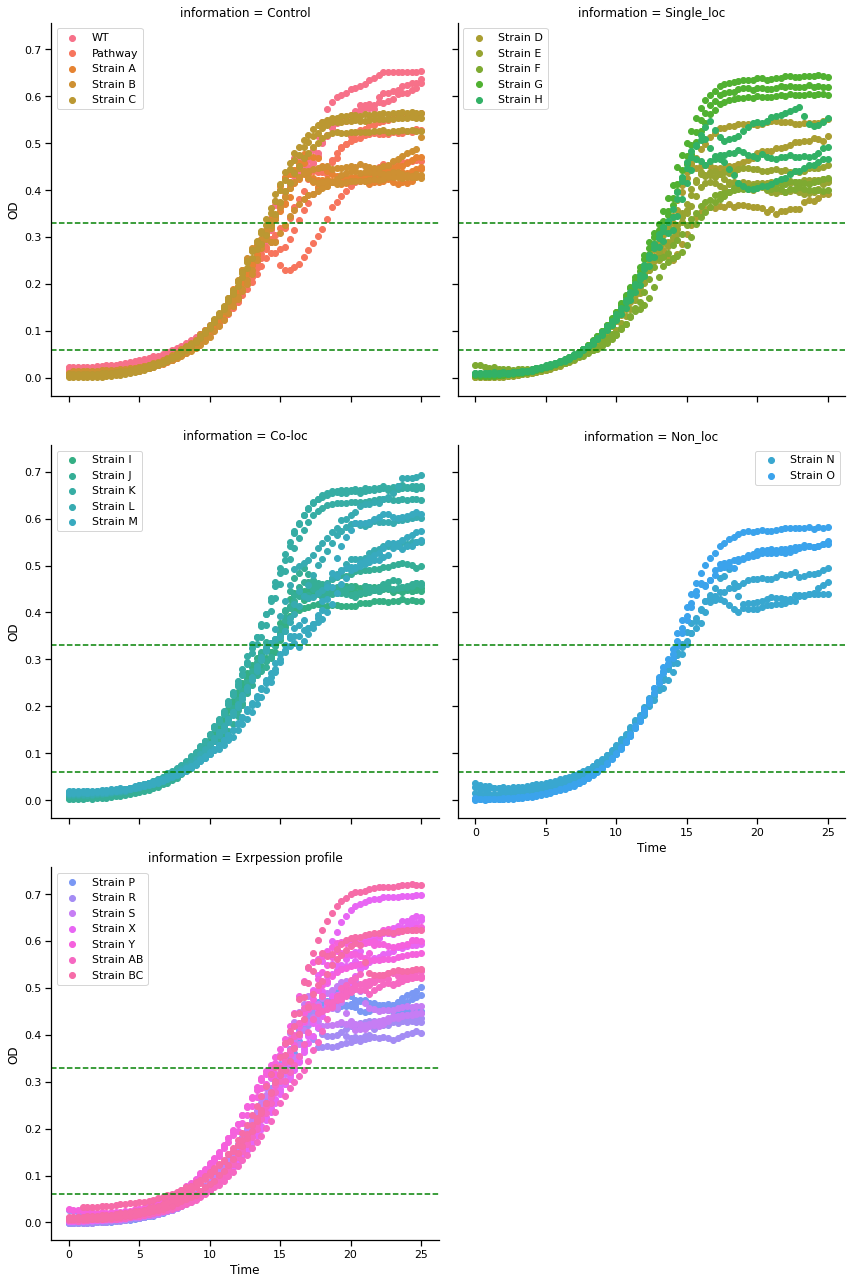

In [2]:
gr = df.groupby(by = ['Time','Strain', 'information', 'Well', 'Target'], axis= 0, as_index=False, sort= False).mean()
sns.set_context('notebook')
g = sns.FacetGrid(data = gr, col = 'information', hue = 'Strain', col_wrap=2 , height= 6)
g.map(plt.scatter,'Time', 'OD')
for ax in g.axes.ravel():
    ax.legend()
    axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.axhline(0.06, ls='--', c='green')
    ax.axhline(0.33, ls='--', c='green')

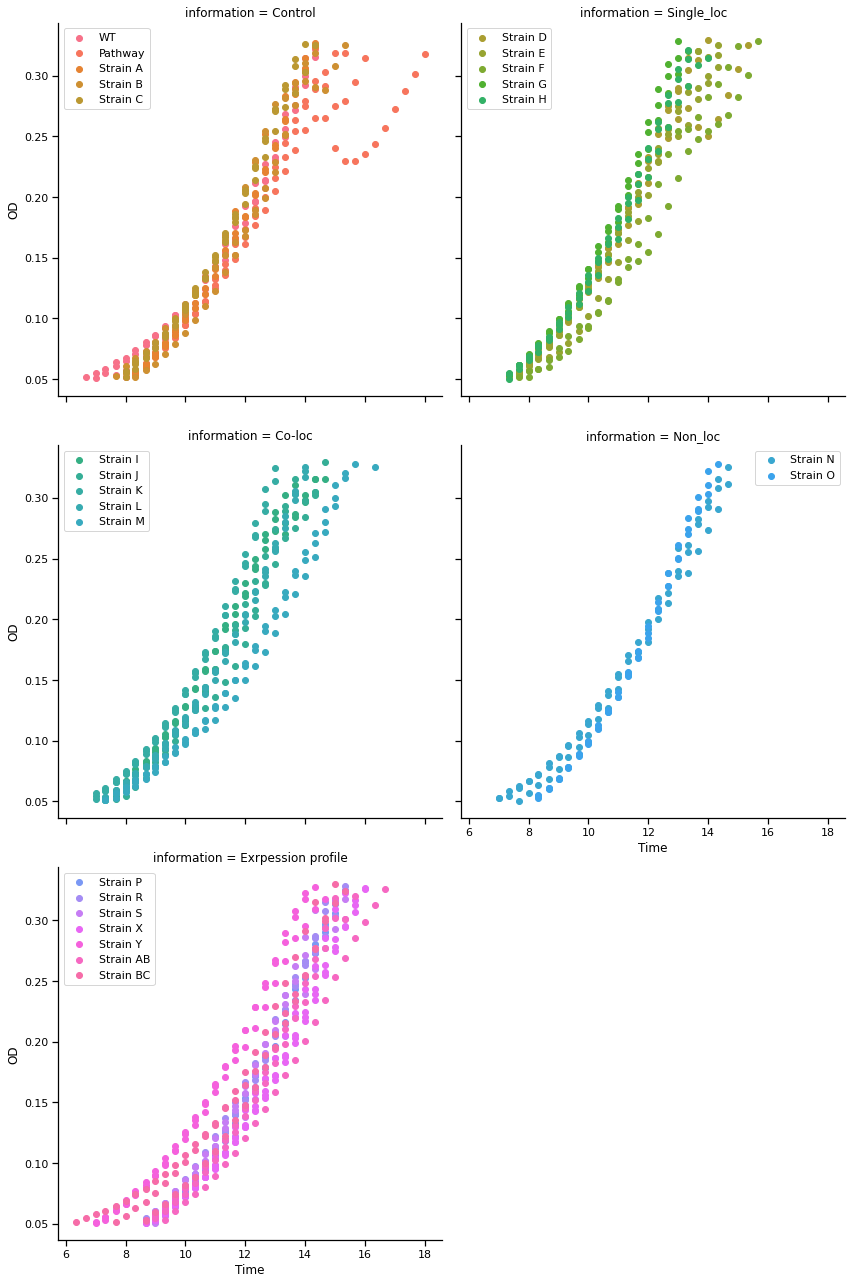

In [3]:
sns.set_context('notebook')
g = sns.FacetGrid(data = gr.loc[(gr['OD'] > 0.05) & (gr['OD'] < 0.33)], col = 'information', hue = 'Strain', col_wrap=2 , height= 6)
g.map(plt.scatter,'Time', 'OD')
for ax in g.axes.ravel():
    ax.legend()

<ipython-input-4-9b2b1e5e8f62>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['log2'] = np.log2(df2['OD'])


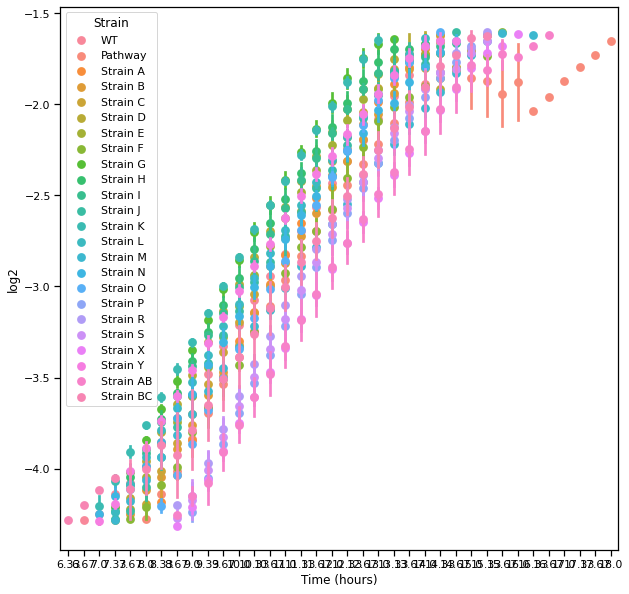

In [4]:
df2 = df.loc[(df['OD']> 0.05) & (df['OD']< 0.33)]
df2['log2'] = np.log2(df2['OD'])
df2.head()

plt.figure(figsize=(10, 10))
sns.pointplot(data = df2, x = 'Time', y = 'log2', join= False, ci = 'sd', hue = 'Strain')
plt.xlabel('Time (hours)')
plt.show()

In [5]:
from scipy.stats import linregress

slopes = []
mean_val = []
median_val =[]
max_val = []
min_val = []
time = np.arange(0, 3, 0.333) # first number should be 0, second number is hour interval, third numberis time interval between measurements

for well in df2.Well.unique():
    
    df3 = df2.loc[df2['Well'] == well, 'log2'].tolist()
    a = 0
    b = len(time)
    val = []
    
    for i in range(0, (len(df3) - (len(time) -1))):
        x = linregress(time, df3[a:b])[0]
        val.append(x)
        a = a +1
        b = b +1
    
    max_val.append(np.max(val))
    mean_val.append(np.mean(val))
    median_val.append(np.median(val))
    min_val.append(np.min(val))

In [6]:
new_df = pd.DataFrame({'Well' : df2['Well'].unique(), 'max_slope': max_val,
                       'mean_slope' : mean_val, 'median_slope' : median_val,'min_slope': min_val})

new_df['information'] = new_df['Well']
new_df['Strain'] = new_df['Well']
new_df['Target'] = new_df['Well']
new_df['Strain'].replace(layout_dict, inplace = True)
new_df['information'].replace(layout_info, inplace = True)
new_df['Target'].replace(target_dict, inplace = True)
new_df

color_dict = dict(zip(new_df.information.unique().tolist(),np.arange(0, len(new_df.information.unique().tolist()))))
color_dict
new_df['color_code'] = new_df['information']
new_df['color_code'].replace(color_dict,inplace = True)

In [ ]:
g = sns.catplot(data = new_df, x = 'Strain', y = 'max_slope', col= 'Target', col_wrap= 3,sharex = False,
                palette= 'viridis', hue = 'information',
            ci = 'sd', kind= 'bar', dodge = False )
for i in g.axes.flat:
    plt.setp(i.get_xticklabels(), rotation=60, ha = 'right')
    i.set(xlabel = None)
    
plt.subplots_adjust(hspace= 1)

In [ ]:
g = sns.catplot(data = new_df, x = 'Strain', y = 'min_slope', col= 'information', col_wrap= 3,sharex = False,
                palette= 'viridis', hue = 'information',
            ci = 'sd', kind= 'bar' ,dodge = False)
for i in g.axes.flat:
    plt.setp(i.get_xticklabels(), rotation=60, ha = 'right')
    i.set(xlabel = None)
    
plt.subplots_adjust(hspace= 1)

In [ ]:
sns.set_context('notebook')
g = sns.FacetGrid(data = df.loc[df['information'].isin(['Single_loc', 'Co-loc'])], 
                  col = 'Target', hue = 'Strain', col_wrap=2 , height= 6)
g.map(plt.scatter,'Time', 'OD')


for ax in g.axes.ravel():
    ax.legend()
    
axes = g.axes.flatten()
for i, ax in enumerate(axes):
    ax.axhline(0.06, ls='--', c='green')
    ax.axhline(0.33, ls='--', c='green')
    


In [ ]:
a = np.arange(0, 75, 10).tolist() #if you want to arange x ticks differently

plt.figure(figsize=(10, 10))
sns.pointplot(data = df.loc[df['Well'].isin(['C10', 'C11','C12', 'E1', 'E2','E3', 'E10', 'E11', 'E12'])], x = 'Time', y = 'OD', join= False, ci = 'sd', hue = 'Strain')
plt.xticks(a)
plt.xlabel('Time (hours)')

plt.axhline(0.06, ls='--', c='green')
plt.axhline(0.33, ls='--', c='green')
plt.show()

In [ ]:
g = sns.catplot(data = new_df, x = 'Strain', y = 'mean_slope', col= 'Target', col_wrap= 3,sharex = False,
                palette= 'viridis', hue = 'information',
            ci = 'sd', kind= 'bar', dodge = False )
for i in g.axes.flat:
    plt.setp(i.get_xticklabels(), rotation=60, ha = 'right')
    i.set(xlabel = None)
    
plt.subplots_adjust(hspace= 1)

In [ ]:
g = sns.catplot(data = new_df, x = 'Strain', y = 'median_slope', col= 'Target', col_wrap= 3,sharex = False,
                palette= 'viridis', hue = 'information',
            ci = 'sd', kind= 'bar', dodge = False )


for i in g.axes.flat:
    plt.setp(i.get_xticklabels(), rotation=60, ha = 'right')
    i.set(xlabel = None)
    
plt.subplots_adjust(hspace= 1)